Use any additional libraries you want, but if you don't explicitly code stuff that I have explicitly asked you to code, you will not get marks.

### Q1. Kernel k-means

Let's try and end our course on a happy note. The smiley dataset you see below is made up of many clusters of points. 

In [1]:
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
from matplotlib import pyplot as plt

np.random.seed(0) # For reproducibility

def getFigure( sizex = 7, sizey = 7 ):
    fig = plt.figure( figsize = (sizex, sizey) )
    return fig

def plot2D( X, fig, color = 'r', marker = '+', size = 100, empty = False ):
    plt.figure( fig.number )
    if empty:
        plt.scatter( X[:,0], X[:,1], s = size, facecolors = 'none', edgecolors = color, marker = marker  )
    else:
        plt.scatter( X[:,0], X[:,1], s = size, c = color, marker = marker )


def genCrescentData( d, n, mu, r, flipped = False ):
    X = np.vstack( (np.cos( np.linspace( 0, np.pi, n ) ), np.sin( np.linspace( 0, np.pi, n ) ) ) ).T
    if flipped:
        X[:,1] = -np.abs( X[:,1] )
    else:
        X[:,1] = np.abs( X[:,1] )
    X = (X * r) + mu
    return X

def genSphericalData( d, n, mu, r ):
    X = rnd.normal( 0, 1, (n, d) )
    norms = lin.norm( X, axis = 1 )
    X = X / norms[:, np.newaxis]
    X = (X * r) + mu
    return X

In [2]:
d = 2
n = 200

mu1 = np.array( [0,0] )
mu2 = np.array( [0,1] )
mu3 = np.array( [0,0] )
mu4 = np.array( [-3,5] )
mu5 = np.array( [3,5] )

tmp1 = genCrescentData( d, n, mu1, 1 )
tmp2 = genCrescentData( d, n, mu2, 5, flipped = True )
tmp3 = genSphericalData( d, n, mu3, 10 )
tmp4 = genSphericalData( d, n, mu4, 1 )
tmp5 = genSphericalData( d, n, mu5, 1 )
X = np.vstack( (tmp1, tmp2, tmp3, tmp4, tmp5) )

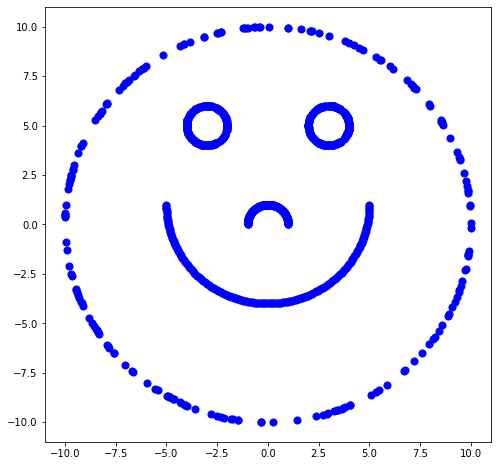

In [3]:
fig = getFigure( 8, 8 )
plot2D( X, fig, size = 50, color = 'b', marker = 'o' )

(a) Can you implement the k-means algorithm to cluster this dataset? Visualize your output. [10 points] 

(b) Implement k-means++ to initialize cluster centers usefully. [5 points]

(c) What value of k gives you the best clustering? Are you happy with the quality of the clustering? [5 points]


(d) I'm going to say that we want to be able to do better than this. So I want you to kernelize your k-means algorithm with a Gaussian kernel. Visualize the clustering output of your kernel k-means algorithm [15 points]

In [4]:
print(f'The shape of X is {X.shape}')

The shape of X is (1000, 2)


In [5]:
class KMeans:
    def __init__(self, K=1, tol = 1e-6):
        self.K = K              # Number of clusters
        self.centroids = None    # Means of the K clusters
        self.tol = tol           # tolerance value for difference between updated and old means
    
    def get_kmeans_centroids(self, X):
#         print(self.K)
        # Choose K data points to be initialised as cluster mean
        np.random.seed(5)
        random_indices = np.random.choice(X.shape[0], size=self.K, replace=False)
        self.centroids = X[random_indices, :]
    
    # Returns square of euclidean distance
    def get_euclidean_distance(self, xn, mu):
        d = np.dot(xn-mu, xn-mu)
        return d
    
    # KMeans++ initialization algorithm
    def get_kmeans_pp_centroids(self, X):
        np.random.seed(0)
        N = X.shape[0]
        self.centroids = []
        
        # Choose first centre randomly
        i = np.random.randint(low=0, high=N)
        self.centroids.append(X[i])

        for i in range(self.K-1):
            prob = np.zeros(N)
            # Find minimum distance to any cluster center
            for n in range(N):
                min_dist = 10000000
                for c in self.centroids:
                    d = np.linalg.norm(X[n] - c)
                    if d < min_dist:
                        min_dist = d
                prob[n] = min_dist**2 # proportionality for now ; will normalize later
            
            prob = prob/np.sum(prob)
            choice = np.random.choice(a=1000, size=1, p=prob) # select one data point with given probability
            self.centroids.append(X[choice[0]])
    
        self.centroids = np.array(self.centroids)
        
    
    def vanilla_kmeans(self,X, K=1):
        np.random.seed(2)
        self.K = K
        
        '''Assign K data points randomly to be the cluster means'''
        self.get_kmeans_centroids(X)
        initial_centers = self.centroids.copy()
        
        # N is the number of training examples
        N = X.shape[0]
        # zn is the cluster assignment
        zn = np.zeros(N, dtype=np.int32)
        
        # iterskeeps track of total number of iterations
        iters = 0
        # assignment turns true if any assignment in current iteration does not match the previous one
        assignment_change = True
        # finds the difference between updated cluster centers and the previious ones
        mean_diff = 10000000
    
        # We use mean_diff and number of iterations as the break condition
        while(mean_diff > self.tol and iters < 100):
            assignment_change = False
            # Loss is the loss normally used in Kmeans
            loss = 0
            mean_diff = 0.0
            
            # ASSIGNMENT OF CLUSTERS FOR N DATA POINTS
            for n in range(N):
                closest_dist = 1000000.0
                # Find k such that (x_n - mu_k)^2 is minimized
                for k in range(self.K):
                    dist = self.get_euclidean_distance(X[n], self.centroids[k])
                    if (dist < closest_dist):
                        if zn[n] != k:
                            assignment_change = True
                        closest_dist = dist
                        zn[n] = k
                # Update loss
                loss += closest_dist
            
            # UPDATE CENTERS
            # Keep a copy of the previous means to get a comparison
            prev_means = np.copy(self.centroids)
            for k in range(self.K):
                Nk = 0
                S = 0
                for n in range(N):
                    if zn[n] == k:
                        S += X[n,:]
                        Nk += 1
                self.centroids[k] = S/Nk
                mean_diff += self.get_euclidean_distance(prev_means[k], self.centroids[k])
            
            # Update iteration number
            iters += 1
                
        return initial_centers, self.centroids, zn, loss

    # KMeans++ Algorithm : Essentially the same as vanilla KMeans but the initialization is different
    def kmeans_pp(self,X, K=1):
        np.random.seed(0)
        self.K = K
        
        # Initialize centers using KMeans++
        self.get_kmeans_pp_centroids(X)
        initial_centers = self.centroids.copy()
        
        # N is the number of training examples
        N = X.shape[0]
        # zn is the cluster assignment
        zn = np.zeros(N, dtype=np.int32)
        
        # iterskeeps track of total number of iterations
        iters = 0
        # assignment turns true if any assignment in current iteration does not match the previous one
        assignment_change = True
        # finds the difference between updated cluster centers and the previious ones
        mean_diff = 10000000
        
        # We use mean_diff and number of iterations as the break condition
        while(mean_diff > self.tol and iters < 100):
            assignment_change = False
            # Loss is the loss normally used in Kmeans
            loss = 0
            mean_diff = 0.0
            
            # ASSIGNMENT OF CLUSTERS FOR N DATA POINTS
            for n in range(N):
                closest_dist = 1000000.0
                # Find k such that (x_n - mu_k)^2 is minimized
                for k in range(self.K):
                    dist = self.get_euclidean_distance(X[n], self.centroids[k])
                    if (dist < closest_dist):
                        if zn[n] != k:
                            assignment_change = True
                        closest_dist = dist
                        zn[n] = k
                # Update loss
                loss += closest_dist
            
            # UPDATE CENTERS
            # Keep a copy of the previous means to get a comparison
            prev_means = np.copy(self.centroids)
            for k in range(self.K):
                Nk = 0
                S = 0
                for n in range(N):
                    if zn[n] == k:
                        S += X[n,:]
                        Nk += 1
                if Nk == 0:
                    self.centroids[k] = np.array([15,15])
                    continue
                self.centroids[k] = S/Nk
                mean_diff += self.get_euclidean_distance(prev_means[k], self.centroids[k])
            
            # Update iteration number
            iters += 1
            
        return initial_centers, self.centroids, zn, loss

In [6]:
kmeans_classifier = KMeans()

In [7]:
lh = []
for k in range(1,15):
    print(f'Trying KMeans with {k} clusters')
    init_means, means, zn, loss = kmeans_classifier.vanilla_kmeans(X,k)
    lh.append(loss)

Trying KMeans with 1 clusters
Trying KMeans with 2 clusters
Trying KMeans with 3 clusters
Trying KMeans with 4 clusters
Trying KMeans with 5 clusters
Trying KMeans with 6 clusters
Trying KMeans with 7 clusters
Trying KMeans with 8 clusters
Trying KMeans with 9 clusters
Trying KMeans with 10 clusters
Trying KMeans with 11 clusters
Trying KMeans with 12 clusters
Trying KMeans with 13 clusters
Trying KMeans with 14 clusters


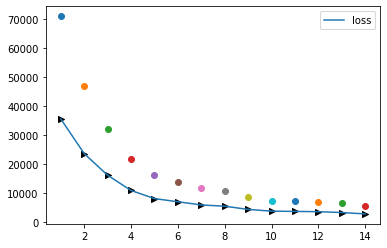

In [8]:
# Plot the loss
plt.plot(range(1,15),lh, label="loss")
for i in range(1,15):
    # Plot the AIC
    plt.scatter(i, lh[i-1], marker = ">", c="black")
    plt.scatter(i, 2*lh[i-1] + i*2)
plt.legend()

Using AIC $k=6$ seems to be the elbow point and that is what we use for visualization

In [9]:
K = 6
init_means, means, zn, loss = kmeans_classifier.vanilla_kmeans(X,K)

In [10]:
means

array([[ 3.61130391e+00,  5.31824149e+00],
       [-5.99228443e+00, -7.02447976e+00],
       [-3.55682490e+00, -2.06789954e+00],
       [-2.22044605e-18,  6.33423518e-01],
       [ 4.57041809e+00, -3.16384527e+00],
       [-3.70003556e+00,  5.32143874e+00]])

In [11]:
init_means

array([[ 4.68208673,  8.83617926],
       [-9.44908984, -3.27333183],
       [-0.99551728,  0.09457981],
       [ 0.98495967,  0.17278439],
       [ 1.59005768, -3.74043422],
       [-3.72129051,  4.30736734]])

In [12]:
loss

6870.789116144849

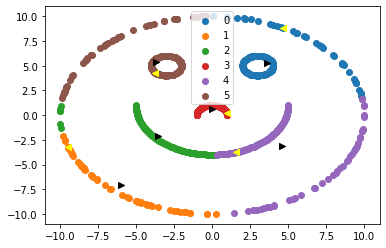

In [13]:
colors = []

for i in range(K):
    plt.scatter(X[zn == i, 0], X[zn == i, 1], label = i)
    plt.scatter(means[i,0], means[i,1], marker='>', c="black") # Final means
    plt.scatter(init_means[i,0], init_means[i,1], marker="<", c="yellow") # Initial means
plt.legend()
plt.show()

In [14]:
lh = []
for k in range(1,16):
    print(f'Trying KMeans with {k} clusters')
    init_means, means, zn, loss = kmeans_classifier.kmeans_pp(X,k)
    lh.append(loss)

Trying KMeans with 1 clusters
Trying KMeans with 2 clusters
Trying KMeans with 3 clusters
Trying KMeans with 4 clusters
Trying KMeans with 5 clusters
Trying KMeans with 6 clusters
Trying KMeans with 7 clusters
Trying KMeans with 8 clusters
Trying KMeans with 9 clusters
Trying KMeans with 10 clusters
Trying KMeans with 11 clusters
Trying KMeans with 12 clusters
Trying KMeans with 13 clusters
Trying KMeans with 14 clusters
Trying KMeans with 15 clusters


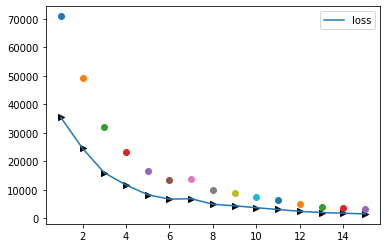

In [15]:
# Plot the loss
plt.plot(range(1,16),lh, label="loss")
for i in range(1,16):
    # Plot the AIC
    plt.scatter(i, lh[i-1], marker = ">", c="black")
    plt.scatter(i, 2*lh[i-1] + i*2)
plt.legend()

In [16]:
K = 6
init_means, means, zn, loss = kmeans_classifier.kmeans_pp(X,K)

In [17]:
means

array([[-3.42781775,  5.44923498],
       [ 9.16486433, -1.92651364],
       [-0.3194197 , -5.76360139],
       [ 1.03263888,  0.14258807],
       [ 3.40543503,  5.40610593],
       [-6.33581918, -1.64385213]])

In [18]:
loss

6757.241050084609

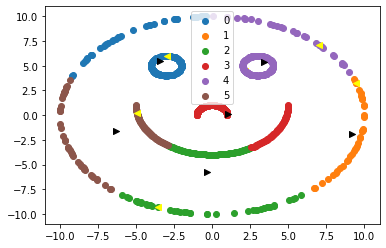

In [19]:
colors = []

for i in range(K):
    plt.scatter(X[zn == i, 0], X[zn == i, 1], label = i)
    plt.scatter(means[i,0], means[i,1], marker='>', c="black") # Final means
    plt.scatter(init_means[i,0], init_means[i,1], marker="<", c="yellow") # Initial means
plt.legend()
plt.show()

### c) 
Using AIC, the value of 6 seems to be a good clustering number for both KMeans and KMeans++. 
However, visually we can see that 5 should be an ideal cluster number. Hence, KMeans with Euclidean Distance is not able to learn the clusters well.  

Also the initial KMeans++ centers were better distributed

## Kernel K Means :
The objective function is $\mathcal{L} = (\phi(x_n) - \phi(\mu_k))^T (\phi(x_n) - \phi(\mu_k)) = k(\mu_k, \mu_k) + k(x_n, x_n) -2k(\mu_k, x_n)$  

Here $\mu_k = \frac{1}{|C_k|} \sum_{n : C_k} \phi(x_n)$  
$k(x_n, x_n) = e^{0} = 1$  
$k(\mu_k, \mu_k) = \frac{1}{|C_k| ^2} \sum_{i : C_k} \sum_{j : C_k} k(x_i, x_j)$  
$k(\mu_k, x_n) = \frac{1}{|C_k|} \sum_{i:C_k} k(x_i, x_n)$ : We need to maximize this value

In [20]:
class KernelKmeans:
    def __init__(self, K=1, gamma = 1, max_iter=40, tol = 0):
        self.K = K              # Number of clusters
        self.centroids = None    # Means of the K clusters
        self.tol = tol           # tolerance value for difference between updated and old means
        self.gamma = gamma
        self.max_iter = max_iter
    
    def get_kmeans_pp_centroids(self, X):
        np.random.seed(3)
        N = X.shape[0]
        self.centroids = []
        i = np.random.randint(low=0, high=N)
        self.centroids.append(X[i])

        for i in range(self.K-1):
            prob = np.zeros(N)
            for n in range(N):
                min_dist = 1000000
                for c in self.centroids:
                    d = np.linalg.norm(X[n] - c)
                    if d < min_dist:
                        min_dist = d
                prob[n] = min_dist**2
            prob = prob/np.sum(prob)
            choice = np.random.choice(a=1000, size=1, p=prob)
            self.centroids.append(X[choice[0]])
        self.centroids = np.array(self.centroids)
    
    # Computing the kernel value
    def gaussian_kernel(self, xi, xj):
        dij = np.linalg.norm(xi - xj)
        return np.exp(-self.gamma * dij**2)
        
    # Computing the kernel matrix
    def compute_gram_matrix(self, X):
        N = X.shape[0]
        self.kernel_matrix = np.zeros((N,N))
        
        for i in range(N):
            j = i
            while j < N:
                self.kernel_matrix[i][j] = self.gaussian_kernel(X[i], X[j])
                self.kernel_matrix[j][i] = self.kernel_matrix[i][j] # kernel is symmetric
                j+=1
                          
    
    def kernel_kmeans(self, X, K=1):
        np.random.seed(1)
        self.K = K
        
        # Initialize centers using KMeans++
        self.get_kmeans_pp_centroids(X)
        
        # N is the number of training examples
        N = X.shape[0]
        # zn is the cluster assignment
        zn = np.zeros(N, dtype=np.int32)
        
        # Initial Assignment of clusters
        for n in range(N):
            closest_dist = 1000000.0
            # Find k such that (x_n - mu_k) is minimized
            for k in range(self.K):
                dist = np.linalg.norm(X[n] - self.centroids[k])
                if (dist < closest_dist):
                    closest_dist = dist
                    zn[n] = k
                
        # iterskeeps track of total number of iterations
        iters = 0
        # assignment turns true if any assignment in current iteration does not match the previous one
        assignment_change = True
        # finds the difference between updated cluster centers and the previious ones
        diff = 10000000
        
        # Compute the gram/kernel matrix
        self.compute_gram_matrix(X)
        
        while(iters < self.max_iter and diff > self.tol):
            old_zn = zn.copy()
            
            Kmu_mu = np.zeros(self.K)
            Ck = np.zeros(N, dtype=np.int32)
            for i in range(N):
                Ck[zn[i]] += 1
            
            # compute k(mu_k, mu_k)
            for k in range(self.K):
                S = 0
                # If no data point belongs to a cluster then we just let it be
                if not Ck[k]:
                    continue
                for i in range(N):
                    if zn[i] == k:
                        for j in range(N):
                            if zn[j] == k:
                                S += self.kernel_matrix[i][j]
                Kmu_mu[k] = S / (Ck[k]**2)  
                        
            # Update cluster assignments            
            for n in range(N):
                min_loss = 10000000
                for k in range(self.K):
                    if not Ck[k]:
                        continue
                    S = 0.0
                    for i in range(N):
                        if (zn[i] == k):
                            S += self.kernel_matrix[n][i]
                    S = S / Ck[k]
                    # Objective function as calculated above
                    obj = self.kernel_matrix[n][n] + Kmu_mu[k] - 2*S
                    if obj < min_loss:
                        min_loss = obj
                        zn[n] = k
            
            same = np.sum(zn == old_zn)
            diff = N - same
            print(diff)
            iters += 1
        
        print(f'The algorithm exited the loop after {iters} iterations')
        return zn  

### Choosing K = 5
We choose K = 5 out of visual intution.  
1 face, 2 eyes, 1 nose, 1 smile. 
After tuning of the hyperparameter $\gamma$, we arrive at a value of around 0.075.

In [21]:
K = 5
kernel_kmeans_classifier = KernelKmeans(K=K, gamma=0.075)
zn = kernel_kmeans_classifier.kernel_kmeans(X,K)

151
42
10
13
12
9
27
26
38
9
0
The algorithm exited the loop after 11 iterations


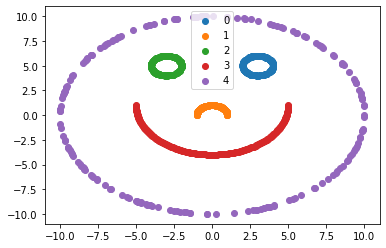

In [22]:
for i in range(K):
    plt.scatter(X[zn == i, 0], X[zn == i, 1], label = i)
#     plt.scatter(means[i,0], means[i,1], marker='>', c="black")
plt.legend()
plt.show()

Multiple values of $\gamma$ gave good results
Ex. $\gamma = 0.1$  

In [23]:
K = 5
kernel_kmeans_classifier = KernelKmeans(K=K, gamma=0.1)
zn = kernel_kmeans_classifier.kernel_kmeans(X,K)

171
28
6
10
11
11
17
19
37
24
0
The algorithm exited the loop after 11 iterations


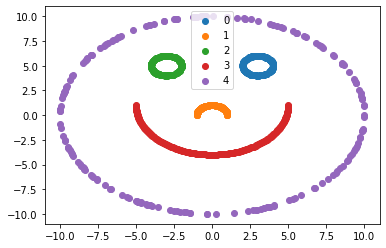

In [24]:
for i in range(K):
    plt.scatter(X[zn == i, 0], X[zn == i, 1], label = i)
#     plt.scatter(means[i,0], means[i,1], marker='>', c="black")
plt.legend()
plt.show()

$\gamma = 1$ gave very fast convergence but failed to capture the clusters properly. The face and smile haven't be assigned properly

In [25]:
K = 5
kernel_kmeans_classifier = KernelKmeans(K=K, gamma=1)
zn = kernel_kmeans_classifier.kernel_kmeans(X,K)

185
1
0
The algorithm exited the loop after 3 iterations


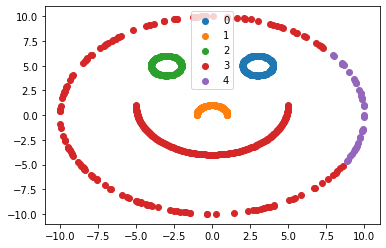

In [26]:
for i in range(K):
    plt.scatter(X[zn == i, 0], X[zn == i, 1], label = i)
#     plt.scatter(means[i,0], means[i,1], marker='>', c="black")
plt.legend()
plt.show()

The other values of $\gamma$ generally failed to capture the 5 clusters properly in less iterations.  
Ex. $\gamma = 5$  

As we can see, it fails to capture all the clusters properly, in particular, the face and smile is clustered together.

In [27]:
K = 5
kernel_kmeans_classifier = KernelKmeans(K=K, gamma=5)
zn = kernel_kmeans_classifier.kernel_kmeans(X,K)

186
8
4
3
0
The algorithm exited the loop after 5 iterations


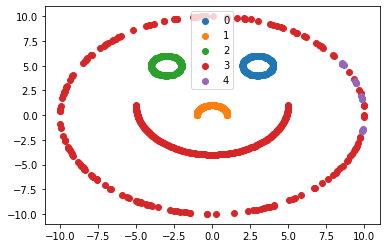

In [28]:
for i in range(K):
    plt.scatter(X[zn == i, 0], X[zn == i, 1], label = i)
#     plt.scatter(means[i,0], means[i,1], marker='>', c="black")
plt.legend()
plt.show()

### Q2. Expectation-Maximization

We saw how to use EM to learn parameters for Gaussian mixture models last week. Specifically, for a GMM described by the set of parameters $\{\pi_k, \mu_k, \Sigma_k \}_{k=1}^K$, we saw that the E-step boils down to figuring out the expected assignment of clusters based on a responsibility judgment proportional to $\pi_k~N(\mu_k, \Sigma_k)$, given curent parameter estimates, followed by using GDA MLE updates assuming the current expected assignment in the M-step to update parameter values.

(a) Can you derive the E-step and M-step for an EM algorithm that would work for a Gaussian mixture model wherein the mixture weights $\pi_k$ are known, and the covariances are restricted to be spherical, i.e. $\Sigma_k = \sigma^2_k I$? [20 points]

(b) Implement this algorithm and show that it works on synthetic data with 3 clusters. If you are unable to derive the EM algorithm for part (a), implement the EM algorithm I showed in the class slides for the standard GMM (5 point penalty for taking this option) [15 points]. 

## a) Derivation
Let $\theta$ denote the parameters for the EM algorithm : $\{\pi_k, \mu_k, \Sigma_k \}_{k=1}^K$   
Using the expression from the lectures, we know that we make updates by trying to solve the following : 

$\hat{\theta} = \text{argmax}_{\theta} \sum_{n=1}^N \sum_{k=1}^K \text{E}[z_{nk}] [\log \pi_k + \log \mathcal{N}(x_n \mid, \mu_k, \sum_k)]$  

We know that $\text{E}[z_{nk}] = \frac{\pi_k \mathcal{N}(x_n \mid \mu_k, \sum_k)}{\sum_{l=1}^K \pi_l \mathcal{N} (x_n \mid \mu_l, \sum_l)} = \gamma_{nk}$ (say)  

The update for $\mu_k$ remains the same. 
The only change will be in the update of $\sigma_k^2$  

Hence, $\mu_k^{(t)} = \frac{1}{N_k} \sum_{n=1}^N \gamma_{nk}^{(t)} x_n$  
And, $(\sigma_k^{(t)})^2 = \frac{\sum_{n=1}^N \gamma_{nk}^{(t)} (x_n - \mu_k^{(t)})^T(x_n - \mu_k^{(t)})}{D \sum_{n=1}^N \gamma_{nk}^{(t)}}$

## Derivation for $\sigma_k^2$  
Consider $\hat{\theta} = \text{argmax}_{\theta} \sum_{n=1}^N \sum_{k=1}^K \text{E}[z_{nk}] [\log \pi_k + \log \mathcal{N}(x_n \mid, \mu_k, \sum_k)]$    

Let the function be termed $\mathcal{L} = \sum_{n=1}^N \sum_{k=1}^K \text{E}[z_{nk}] [\log \pi_k + \log \frac{1}{\sqrt{(2 \pi)^D |\sum_k|}} e^{(\frac{-1}{2} (x_n - \mu_k)^T \sum_k^{-1} (x_n - \mu_k)} ]$  
Notice that $\sum_k^{-1} = \frac{1}{\sigma_k^2}I_D$  
So $\mathcal{L} = \sum_{n=1}^N \sum_{k=1}^K \text{E}[z_{nk}] [\log \pi_k + \log \frac{1}{\sqrt{2 \pi \sigma_k^{2D}}} -\frac{1}{2\sigma_k^2} (x_n - \mu_k)^T (x_n - \mu_k)]$  
$\frac{\partial \mathcal{L}}{\partial \sigma_{k}^2} = \sum_{n=1}^N \text{E}[z_{nk}] [\frac{-1}{2 \sigma_k^2} D (\sigma_k^2)^{D-1} + \frac{1}{2 (\sigma_k^2)^2} (x_n - \mu_k)^T (x_n - \mu_k)] = 0$  
Hence, $(\sigma_k)^2 = \frac{\sum_{n=1}^N \gamma_{nk} (x_n - \mu_k)^T(x_n - \mu_k)}{D \sum_{n=1}^N \gamma_{nk}}$

In [29]:
## Custom function that generates the three clusters 
def generate_data():
    
    N = 1000 ## Total number of points
    sigma = np.array([0.5, 0.8, 1]) ## Sigma_k values for the clusters
    means = np.array([[7,10], [-5,4], [0,-7]]) ## Means of the clusters
    pi = np.array([0.35, 0.5, 0.15]) ## Probabilities associated with clusters
    
    ## Preparing the covariance matrix
    covs = [(sigma[0]*sigma[0])*np.identity(2), (sigma[1]*sigma[1])*np.identity(2), (sigma[2]*sigma[2])*np.identity(2)]
    
    ## Choosing points to go in clusters according to pi probabilities
    indices = np.random.choice(np.arange(3), N, p = pi)
    
    ## Generating random draws from multivariate normals for dataset 
    X = np.zeros([N,2])
    for i in range(N):
        X[i] = np.random.multivariate_normal(means[indices[i]], covs[indices[i]])
    
    plt.scatter(X[:,0], X[:,1], c = 'b')
    return X, means, pi, sigma

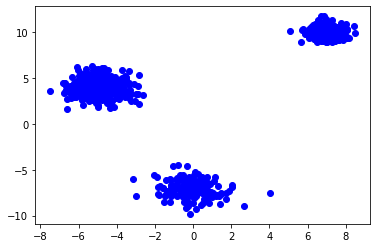

In [30]:
np.random.seed(20)
X_em, means, pi, sigma = generate_data()

In [31]:
from scipy.stats import multivariate_normal

In [32]:
def Expectation_Maximization(X, pi, mu, sigma):
    # NOTE : sigma here actually contains sigma^2, ie. the variance
    # Parameters for EM algorithm
    K = pi.shape[0]
    N = X.shape[0]
    tol = 1e-7
    max_iters = 20
    mean_diff = 1000
    iters = 0
    
    plt.scatter(X[:,0], X[:,1], c = 'b')
    
    while (iters < max_iters and mean_diff > tol):
        # Store old paramters for comparison
        old_mu = mu.copy()
        old_sigma = sigma.copy()
        
        # Do E-step
        E = np.zeros((N,K))
        
        # Expectation step
        for n in range(N):
            for k in range(K):
                E[n,k] = pi[k] * multivariate_normal.pdf(x=X[n], mean=mu[k], cov=sigma[k]*np.identity(2))
            E[n,:] = E[n,:] / np.sum(E[n, :])
                
        # Do M-step
        new_mu = np.zeros((K,2))
        new_sigma = np.zeros(K)
        
        # Update mu and sigma
        for k in range(K):
            for n in range(N):
                new_mu[k] += E[n,k]*X[n]
                new_sigma[k] += E[n,k] * ((X[n]-mu[k]).T @ (X[n] - mu[k]))
            
            Nk = np.sum(E[:,k])
            new_mu[k] = new_mu[k] / Nk
            new_sigma[k] = new_sigma[k]/(2*Nk)
        
        # Check difference for tolerance
        mean_diff = np.linalg.norm(new_mu - old_mu) + np.linalg.norm(new_sigma - old_sigma)
        mu = new_mu
        sigma = new_sigma
        iters+=1
        print(mean_diff)
        
        # Helps to visualize the path of mu during iterations of EM algo
        plt.scatter(mu[0][0], mu[0][1], marker="x")
        plt.scatter(mu[1][0], mu[1][1], marker=">")
        plt.scatter(mu[2][0], mu[2][1], marker="*")
    
    plt.show()
    return mu, sigma

In [33]:
mu_0 = np.array([np.mean(X_em[:,0]), np.mean(X_em[:,1])])
init_mu = np.array([[mu_0[0], mu_0[1]], 
                    [mu_0[0], mu_0[1]],
                    [mu_0[0], mu_0[1]]])

var = np.var(X)
init_var = np.array([var, var, var])

In [34]:
for k in range(3):
    init_mu[k] += np.random.multivariate_normal([0,0], np.identity(2))

21.977209102888168
6.212246210213465
9.028930477856537
13.652085504313057
13.654547182878527
7.950873949748189
15.230814101380176
16.093352688062847
2.621562581966723
0.010488418813785889
1.0833329460112301e-11


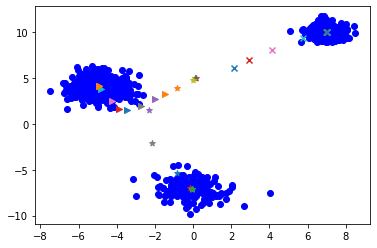

In [35]:
mu, sigma = Expectation_Maximization(X_em, pi, init_mu, init_var)

In [36]:
mu

array([[ 7.01358799,  9.98774688],
       [-4.951721  ,  4.05562026],
       [-0.08053866, -7.11441742]])

In [37]:
pi

array([0.35, 0.5 , 0.15])

In [38]:
sigma

array([0.24633382, 0.62953437, 0.96861292])

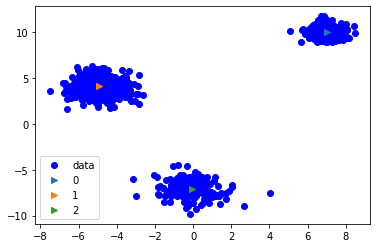

In [39]:
plt.scatter(X_em[:,0], X_em[:,1], c = 'b', label = "data")
for i in range(3):
    plt.scatter(mu[i][0], mu[i][1],marker=">", label=i)
plt.legend()
plt.show()